In [1]:
#!/bin/bash
!curl -L -o archive.zip\
https://www.kaggle.com/api/v1/datasets/download/akshitmadan/hand-sign-language-az

!unzip archive.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25.1M  100 25.1M    0     0  29.7M      0 --:--:-- --:--:-- --:--:-- 29.7M
Archive:  archive.zip
  inflating: Sign Language Dataset/test/A/0.jpg  
  inflating: Sign Language Dataset/test/A/1.jpg  
  inflating: Sign Language Dataset/test/A/10.jpg  
  inflating: Sign Language Dataset/test/A/11.jpg  
  inflating: Sign Language Dataset/test/A/12.jpg  
  inflating: Sign Language Dataset/test/A/13.jpg  
  inflating: Sign Language Dataset/test/A/14.jpg  
  inflating: Sign Language Dataset/test/A/15.jpg  
  inflating: Sign Language Dataset/test/A/16.jpg  
  inflating: Sign Language Dataset/test/A/17.jpg  
  inflating: Sign Language Dataset/test/A/18.jpg  
  inflating: Sign Language Dataset/test/A/19.jpg  
  inflating: Sign Language Dataset/test/A/2.jpg  
  

In [2]:
import torch
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt

#Hyperparameters
batch_size = 16
num_epoch = 5
num_classes = 26
learning_rate = 0.001

# Step 1: Choose a Pre-Trained Model

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


# Step 2: Load and modify the model

In [4]:
classes = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
           'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, num_classes)   # change the output features
                                                        # of the fc to 26

# Step 3: Freeze the pretrained model

In [5]:

# Freeze all layers
for param in model.parameters():
  param.requires_grad = False

# Unfreeze the fully connected layer
for param in model.fc.parameters():
  param.requires_grad = True

# Step 4: Pre-process the data

In [6]:
transform = [torchvision.transforms.Resize((224,224)),
             torchvision.transforms.ToTensor(),
             torchvision.transforms.Normalize(mean = (0.5,0.5,0.5), std = (0.5,0.5,0.5))]

transformation = torchvision.transforms.Compose(transform)

data_path = '/content/Sign Language Dataset/train'

full_dataset = torchvision.datasets.ImageFolder(root = data_path, transform = transformation)


# split into training and testing dataset
train_size = int(0.7 * len(full_dataset))   # 70% of dataset go to training set
test_size = len(full_dataset) - train_size  # 30% of dataset go to testing set
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


# setting up the data loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = batch_size,
                                               shuffle = True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = batch_size,
                                              shuffle = False)

# Step 5: Make a function to test the model

In [7]:
def test(model, test_loader, device):
  model.eval()

  with torch.no_grad():   # disable gradient computation
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      predicted_output = model(images)
      _, prediction = torch.max(model(images), dim = 1)

      correct += (prediction == labels).sum().item()
      total += labels.size(0)

      acc = correct/total*100

  print(f'correct: {correct}\ntotal: {total}\naccuracy: {acc}\n')

  return acc

# Step 6: Train the model and test it

In [8]:
# loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Train The model
epoch_loss = 0
loss_list = []
training_loss = []
training_acc = []
epoch_nums = []

total_step = len(train_loader)
model.train()

for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(train_loader):

        model.train()

        # training
        images = images.to(device)
        labels = torch.eye(num_classes)[labels].to(device)

        # Forward pass
        outputs = model(images)
        outputs = torch.nn.functional.log_softmax(outputs,dim=1)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # running loss
        epoch_loss += loss.item()

        loss_list.append(epoch_loss)

        if (i+1) % 10 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epoch,
                                                                    i+1, total_step,
                                                                    loss.item()))

    # training loss
    avg_loss = epoch_loss /(i+1)
    training_loss.append(avg_loss)

    # accuracy
    accuracy = test(model,test_loader,device)
    training_acc.append(accuracy)

    epoch_nums.append(epoch)
    epoch_loss = 0

Epoch [1/5], Step [10/113], Loss: 3.1702
Epoch [1/5], Step [20/113], Loss: 2.5381
Epoch [1/5], Step [30/113], Loss: 1.9464
Epoch [1/5], Step [40/113], Loss: 2.1970
Epoch [1/5], Step [50/113], Loss: 1.8487
Epoch [1/5], Step [60/113], Loss: 1.5243
Epoch [1/5], Step [70/113], Loss: 1.4784
Epoch [1/5], Step [80/113], Loss: 1.7082
Epoch [1/5], Step [90/113], Loss: 1.5650
Epoch [1/5], Step [100/113], Loss: 1.1621
Epoch [1/5], Step [110/113], Loss: 1.0852
correct: 689
total: 771
accuracy: 89.3644617380026

Epoch [2/5], Step [10/113], Loss: 0.9892
Epoch [2/5], Step [20/113], Loss: 0.6196
Epoch [2/5], Step [30/113], Loss: 0.8878
Epoch [2/5], Step [40/113], Loss: 0.9574
Epoch [2/5], Step [50/113], Loss: 0.7218
Epoch [2/5], Step [60/113], Loss: 0.7206
Epoch [2/5], Step [70/113], Loss: 0.4572
Epoch [2/5], Step [80/113], Loss: 0.5397
Epoch [2/5], Step [90/113], Loss: 0.5766
Epoch [2/5], Step [100/113], Loss: 0.4236
Epoch [2/5], Step [110/113], Loss: 0.4513
correct: 752
total: 771
accuracy: 97.53566

# Step 7: Evaluate the model

[[27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0 23  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0 25  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0 39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0 30  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0

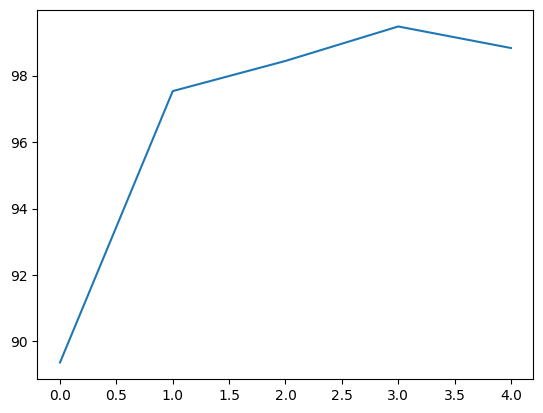

In [9]:
plt.plot(epoch_nums,training_acc)

from sklearn.metrics import confusion_matrix, classification_report

y_pred = []
y_true = []

for images,labels in test_loader:
  predicted_output = model(images) # input into model becomes images

  _,predicted = torch.max(predicted_output,1)
  y_pred.extend(predicted.data.cpu().numpy())

  labels = labels.data.cpu().numpy()
  y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
print(classification_report(y_true,y_pred))
